## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [39]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [41]:
#read the dataset
df = pd.read_csv('ab_data.csv')

#view the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [42]:
len(df)

294478

c. The number of unique users in the dataset.

In [43]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [44]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [45]:
len(df.query('group == "treatment" and landing_page != "new_page"')) + len(df.query('group != "treatment" and landing_page == "new_page"'))


3893

f. Do any of the rows have missing values?

In [46]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [77]:
#drop the mismatch rows

df2 = df.drop(df.query('group == "treatment" and landing_page != "new_page"').index)
df2 = df2.drop(df2.query('group == "control" and landing_page != "old_page"').index)

In [78]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [79]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [80]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [81]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [82]:
df2.drop(labels=1899, inplace=True)


a. What is the probability of an individual converting regardless of the page they receive?

In [83]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [84]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [85]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [86]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

From these descriptive statistics results:
- The probability of receiving the new page is 50.01%, which is a good thing.
- Also it shows that there is no sufficient evidence to say that the new treatment page leads to more conversions.
- As only 12.04% in the control group and 11.88% in the treatment group converted. But that summary can change after conducting the hypothesis testing.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- $H_{0}: P_{new} - P_{old} \leq 0$

- $H_{1}: P_{new} - P_{old} > 0$

- $\alpha: 0.05$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [88]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [89]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [148]:
#number of the users who recieved the new page
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [149]:
#number of the users who recieved the old page
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [92]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11868419241621361

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [93]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.11942260831256797

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [97]:
# A result of only one simulation
dif=new_page_converted.mean() - old_page_converted.mean()
dif

-0.000738415896354358

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [150]:
# run the simulation 10000 times
p_diffs = []
for _ in range (10000):
    old_page_converted = np.random.choice([0,1], size = n_old, replace=True, p=[1-p_old, p_old]).mean()
    new_page_converted = np.random.choice([0,1], size = n_new, replace=True, p=[1-p_new,p_new]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

p_diffs = np.array(p_diffs)  # convert p_diffs to numpy array

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

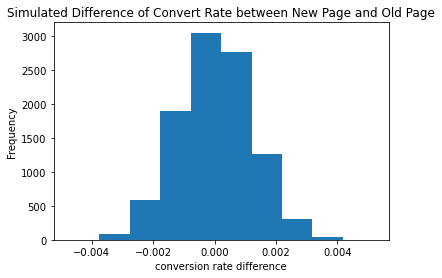

In [151]:
# plot histogram of the sampling distribution p_diffs
plt.hist(p_diffs)
plt.xlabel('conversion rate difference')
plt.ylabel('Frequency')
plt.title('Simulated Difference of Convert Rate between New Page and Old Page');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [111]:
df_treatment = df2.query('group == "treatment"')
df_control = df2.query('group == "control"')
# display observed difference
actual_diff = df_treatment.converted.mean() - df_control.converted.mean()
actual_diff

-0.0015782389853555567

In [156]:
# display the proportion of p_diffs greater than the observe difference
p_val=(p_diffs > actual_diff).mean()
p_val

0.9094

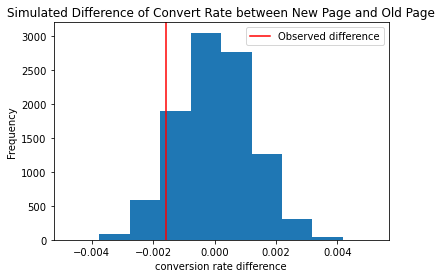

In [155]:
plt.hist(p_diffs)
plt.xlabel('conversion rate difference')
plt.ylabel('Frequency')
plt.axvline(actual_diff,color='red', label="Observed difference") #  plot the line of the actual difference observed ss
plt.title('Simulated Difference of Convert Rate between New Page and Old Page')
plt.legend()
plt.show();

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- This  computed value called the p-value, which is is the probability of observing our chosen statistic or one more extreme in favour of the alternative, if the Null hypothesis is true. The smaller the P-Value, the stronger the evidence against the null hypothesis and in favour of the alternative hypothesis.

- In this case, the p-value = 0.9 ,which is greater than 5% of Type I error rate, this means there is a high probability conversion rate will be larger under null hypothesis.
- This leads to fail rejecting the the null hypothesis. As we couldn't find sufficient evidence to support that new page has conversion rate greater than the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [115]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [123]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [125]:
from scipy.stats import norm

display(norm.cdf(z_score)) # display how significant our z-score is
display(norm.ppf(1-(0.05))) # calculate the critical z_term value at 95% confidence interval

0.9050583127590245

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The z-score of 1.31 is less than the critical value of 1.64, also The p-value is 0.9 which is greater than the alpha of 0.05. So, we fail to reject the null hypothesis.
- With a 95% confidence level, the converted rate of the new page is less than the old page.
- Finally, this proves that the z-test result align with the findings we got during the bootstrapping. in parts j. and k.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

- In this case, we will be performing logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [157]:
df2['intercept'] = 1 # add intercept to dataframe
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']  # create dummy variables from the group column and add them to dataframe

In [158]:
df2.head() # check that the columns are added 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [130]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [131]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:               8.077e-06
Time:                        05:03:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

- The p-value of the logistic regression model equals to 0.19, which is different than what we have got in J & K parts, because at these parts we did a one-tailed test, but in the logistic regression we have performed a two-tailed test.

- Also The null and alternative hypothesis model assumed that probability of converted users in both old and new page are equal to each other.

- $H_{0}: P_{new} - P_{old} = 0$

- $H_{1}: P_{new} - P_{old} != 0$

- In both cases, the results do not support the alternative hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- It is good to consider other factors to add into the regression model, as they might influence the conversion rate, and help in identifying the relative influence of one or more predictor variables to the response value. 
- Though, there are maybe disadvantages to add additional terms, appears in some potential problems as non-linearity of the response-predictor relationships or multi-collinearity, which occurs when we have highly correlated predictors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? - Provide the statistical output as well as a written response to answer this question.

In [134]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [136]:
# show the catagories of country column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [138]:
# Add dummy variables for country column
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [139]:
# Fit the Linear Model 
df_new['intercept'] = 1
lm = sm.Logit(df_new.converted,df_new[['intercept','ab_page','US', 'CA']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:               2.323e-05
Time:                        06:31:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

#### My Answer:
- The country does not have impact on the conversion rate, as the P-value for each country is greater than 0.05 α

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [144]:
# add interaction between page and country
df_new['CA_page'] = df_new['ab_page'] * df_new['CA']
df_new['US_page'] = df_new['ab_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,US_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [143]:
# Fit the logistic regression model 
# use UK as a baseline
df_new['intercept'] = 1
reg_mod = sm.Logit(df_new.converted,df_new[['intercept','ab_page','US', 'CA','US_page','CA_page']])
rslt = reg_mod.fit()
rslt.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:               3.482e-05
Time:                        06:40:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

In [145]:
np.exp(rslt.params)

intercept    0.136392
ab_page      1.010893
US           1.005761
CA           0.988285
US_page      0.969090
CA_page      0.924703
dtype: float64

In [146]:
1 / np.exp(rslt.params)

intercept    7.331806
ab_page      0.989224
US           0.994272
CA           1.011854
US_page      1.031896
CA_page      1.081428
dtype: float64

In [147]:
df.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64

#### Summary 
- The results of p_values are all greater than 0.05, which means the new variables that show the interactions between country and page, did not show any influence for landing page in the US or CA on landing page in the other countries. Even it decreased the significance of the original “US” and “CA” columns. So these new interaction variables should not be added to the model.
- There is no substantial difference in the conversion rates for control group and treatment group.
- Thus we fail to reject the null hypothesis.


<a id='conclusions'></a>
## Conclusions

- From the probability, A/B testing and logistic regression results, it shows that there is no sufficient evidence to suggest that the new page increase the conversion rate than the old one.

